# prepare dataset and libraries

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:\\Users\\Saeth\\Downloads\\WIC_default_V4_emb.csv')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
from ax import optimize

In [5]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import tagset_mapping, map_tag
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore") 

In [6]:
maxy = max(data['freq'])
maxy

7477811

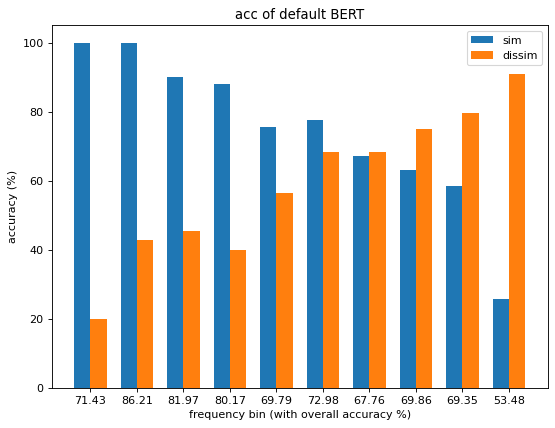

overall acc:  69.357


In [7]:
# baseline
no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)} # sim[true], sim[all], dissim[true], dissim[all]

score = 0 # overall acc
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2)))

    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1
#print(rec)
figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35
y=[]
for g in list(rec.values()):
    if g[1] != 0:
        y.append((g[0]/g[1])*100)
    else:
        y.append(0)
plt.bar(ind, y, width, label='sim')
y2=[]
for h in  list(rec.values()):
    if h[3] !=0:
        y2.append((h[2]/h[3])*100)
    else:
        y2.append(0)
plt.bar(ind + width, y2, width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('accuracy (%)')
plt.xlabel('frequency bin (with overall accuracy %)')
plt.title('acc of default BERT')

y3=[]
for h in list(rec.values()):
    if h[3]+h[1] != 0:
        y3.append((h[0]+h[2])/(h[3]+h[1]))
    else:
        y3.append(0)
default_result = ["{:.2f}".format(k*100) for k in y3]
default_all_acc = [k*100 for k in y3]

plt.xticks(ind + width/2, default_result)
plt.legend(loc='best')
plt.show()

default_gap = np.array([abs(i) for i in np.array(y)-np.array(y2)])
default_acc = (score/len(data))*100
print('overall acc: ', "{:.3f}".format(default_acc))

In [8]:
default_gap

array([80.        , 57.14285714, 44.54545455, 48.11881188, 19.21653035,
        9.3218436 ,  1.40467402, 11.64641845, 21.17998327, 65.05875077])

In [9]:
default_acc

69.35722201699298

In [10]:
default_all_acc

[71.42857142857143,
 86.20689655172413,
 81.9672131147541,
 80.16528925619835,
 69.78851963746223,
 72.98013245033113,
 67.76232616940582,
 69.8639942734431,
 69.35123042505593,
 53.47826086956522]

In [11]:
# a single linear adjustment approach
def med_freq(m1, t1):
    score = 0
    no_bin=10
    # 3399860
    # 3895208
    move = np.log2(maxy)/no_bin
    rec= {i+1:[0,0,0,0] for i in range(10)}
    for index in range(len(data)):
        emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
        emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
        log2_freq = data.iloc[index]['log2freq']
        alpha = (-m1* log2_freq) + 1 + t1*m1
        # non_stop words m1 lowest
        cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)

        
        if cos >= 0.5447465400847086:
            temp = 'T'
        else:
            temp = 'F'
        lol=False
        label = data.iloc[index]['human_label']
        if temp == label:
            score+=1
            lol=True
        for j in range(10):
            left = j*move
            if log2_freq<left:
                if label == 'T':
                    rec[j][1]+=1
                    if lol:
                        rec[j][0]+=1
                else:
                    rec[j][3]+=1
                    if lol:
                        rec[j][2]+=1
                break
            if j==9:
                if label == 'T':
                    rec[j+1][1]+=1
                    if lol:
                        rec[j+1][0]+=1
                else:
                    rec[j+1][3]+=1
                    if lol:
                        rec[j+1][2]+=1
    y = [(g[0]/g[1])*100 for g in list(rec.values())] # sim
    y2=[(h[2]/h[3])*100 for h in list(rec.values())] # dissim
    y3 = [((h[0]+h[2])/(h[3]+h[1]))*100 for h in list(rec.values())]
    all_gap = default_gap - np.array([abs(i) for i in np.array(y)-np.array(y2)])
    delta_gap = (1/no_bin)*np.sum(all_gap)
    delta_acc = (score/len(data))*100 - default_acc
    delta_all_acc = (1/no_bin)*np.sum(np.array(y3) - np.array(default_all_acc))
    return (delta_gap + delta_all_acc + delta_acc)/100

# train the model

In [13]:
import timeit

In [15]:
start = timeit.default_timer()
best_parameters, best_values, experiment, model2 = optimize(
        parameters=[
            {
                "name": "m1",
                "type": "range",
                "bounds": [0.001, 0.1],
            },
            {
                "name": "t1",
                "type": "range",
                "bounds": [12.0,18.0],
            },
            ],
            # Booth function
            evaluation_function=lambda p: med_freq(p['m1'], p['t1']),
            minimize=False,
            #parameter_constraints=["m1 <= m2", 'm2 <= m3'],
            total_trials=100,
        )
print(best_parameters)
print(best_values)
stop = timeit.default_timer()
print('time (Sec): ', stop-start)

[INFO 09-23 04:52:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter m1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-23 04:52:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter t1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-23 04:52:52] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='m1', parameter_type=FLOAT, range=[0.0299, 0.0301]), RangeParameter(name='t1', parameter_type=FLOAT, range=[13.99, 14.01])], parameter_constraints=[]).
[INFO 09-23 04:52:52] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 09-23 04:52:52] ax.modelbridge.dispatch

[INFO 09-23 05:02:58] ax.service.managed_loop: Running optimization trial 88...
[INFO 09-23 05:03:05] ax.service.managed_loop: Running optimization trial 89...
[INFO 09-23 05:03:13] ax.service.managed_loop: Running optimization trial 90...
[INFO 09-23 05:03:20] ax.service.managed_loop: Running optimization trial 91...
[INFO 09-23 05:03:27] ax.service.managed_loop: Running optimization trial 92...
[INFO 09-23 05:03:34] ax.service.managed_loop: Running optimization trial 93...
[INFO 09-23 05:03:42] ax.service.managed_loop: Running optimization trial 94...
[INFO 09-23 05:03:49] ax.service.managed_loop: Running optimization trial 95...
[INFO 09-23 05:03:56] ax.service.managed_loop: Running optimization trial 96...
[INFO 09-23 05:04:04] ax.service.managed_loop: Running optimization trial 97...
[INFO 09-23 05:04:11] ax.service.managed_loop: Running optimization trial 98...
[INFO 09-23 05:04:18] ax.service.managed_loop: Running optimization trial 99...
[INFO 09-23 05:04:26] ax.service.managed

{'m1': 0.029909346846368652, 't1': 13.99}
({'objective': 0.1539639410347703}, {'objective': {'objective': 2.0804454999002724e-10}})
time (Sec):  702.7330690000001


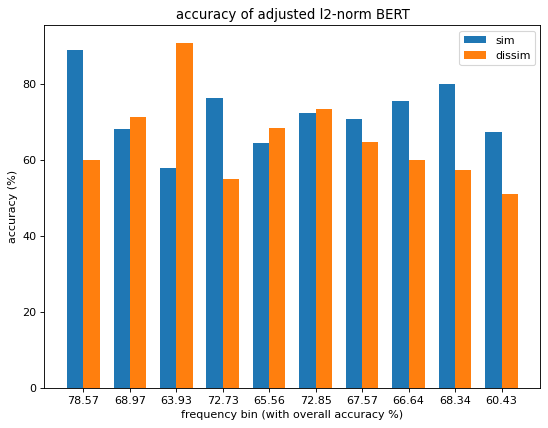

overall acc:  67.880


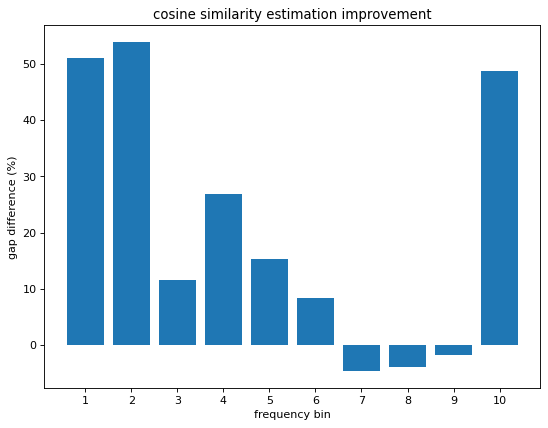

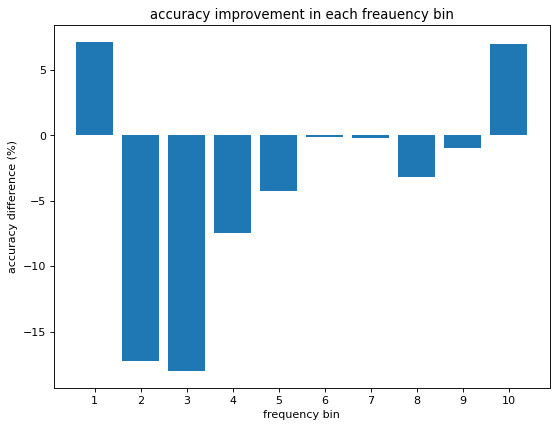

Delta accuracy (%):  -1.478
Average gap improvement (%):  20.543
objective function:  0.153


In [13]:
# alpha = -0.01* bin + 1.06

no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)}
m1 = 0.03
t1 = 14
score = 0
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    alpha = (-m1* log2_freq) + 1 + t1*m1
    # non_stop words m1 lowest
    cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1

figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35     
y = [(g[0]/g[1])*100 for g in list(rec.values())]
plt.bar(ind, y, width, label='sim')
y2=[(h[2]/h[3])*100 for h in list(rec.values())]
plt.bar(ind + width, y2, width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('accuracy (%)')
plt.xlabel('frequency bin (with overall accuracy %)')
plt.title('accuracy of adjusted l2-norm BERT')

y3 = ["{:.2f}".format(((h[0]+h[2])/(h[3]+h[1]))*100) for h in list(rec.values())]
plt.xticks(ind + width/2, y3)
plt.legend(loc='best')
plt.show()


print('overall acc: ', "{:.3f}".format((score/len(data))*100))

# obj function
all_gap = default_gap - np.array([abs(i) for i in np.array(y)-np.array(y2)])
delta_gap = (1/no_bin)*np.sum(all_gap)
delta_acc = (score/len(data)*100) - default_acc
y3 = [((h[0]+h[2])/(h[3]+h[1]))*100 for h in list(rec.values())]
delta_all_acc = (1/no_bin)*np.sum(np.array(y3) - np.array(default_all_acc))
obj = (delta_gap + delta_all_acc + delta_acc)/100

figure(figsize=(8, 6), dpi=80)
#print(y2)
plt.bar(x, all_gap)
plt.xlabel('frequency bin')
plt.ylabel('gap difference (%)')
plt.title('cosine similarity estimation improvement')
plt.xticks(x)
plt.show()

figure(figsize=(8, 6), dpi=80)
#print(y2)
plt.bar(x, np.array(y3) - np.array(default_all_acc))
plt.xlabel('frequency bin')
plt.ylabel('accuracy difference (%)')
plt.title('accuracy improvement in each freauency bin')
plt.xticks(x)
plt.show()

print('Delta accuracy (%): ', "{:.3f}".format(delta_acc))
print('Average gap improvement (%): ', "{:.3f}".format(delta_gap))
print('objective function: ', "{:.3f}".format(obj))